# Data Science with PySpark

Instrucciones: Lea cuidadosamente las preguntas, escriba el código correspondiente y ejecútelo para mostrar sus resultados.

Antes de continuar:

Asegúrese de contar con los siguientes componentes instalados en la computadora que realizará el examen.

1. Python - Se recomienda Python 3.7 pues en algunos casos Python 3.8 causa algunos problemas de compatibilidad con PySpark
2. PySpark - Se recomienda PySpark 2.x
3. Jupyter Notebook - Se recomienda instalar la distribución Anaconda3 - 2020.02 que contiene Python 3.7. Esto puede descargarse de https://repo.anaconda.com/archive/



Importante: Todos los ejercicios deberán realizarse con funciones de NumPy, Pandas o PySpark (no podrán crearse vistas temporales para realizarse en SQL, salvo que se indique lo contrario).

# Import dependencies

In [63]:
from pyspark.sql import functions as sf
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline


import pandas as pd
import numpy as np
np.random.seed(0)
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go

# Spark Core

1.1 Utilizando NumPy, construya un arreglo con 50 elementos aleatorios distribuidos de forma normal con media 50 y desviación estándar 10. Imprima el arreglo.

In [64]:
a = np.random.normal(50,10,50)
print(a)

[67.64052346 54.00157208 59.78737984 72.40893199 68.6755799  40.2272212
 59.50088418 48.48642792 48.96781148 54.10598502 51.44043571 64.54273507
 57.61037725 51.21675016 54.43863233 53.33674327 64.94079073 47.94841736
 53.13067702 41.45904261 24.47010184 56.53618595 58.64436199 42.5783498
 72.69754624 35.45634325 50.45758517 48.1281615  65.32779214 64.6935877
 51.54947426 53.7816252  41.12214252 30.19203532 46.52087851 51.56348969
 62.30290681 62.02379849 46.12673183 46.97697249 39.51447035 35.79982063
 32.93729809 69.50775395 44.90347818 45.61925698 37.4720464  57.77490356
 33.86102152 47.8725972 ]


## Build spark core object
Construya el objeto de Spark (Core) que le permita trabajar con objetos RDD.

In [198]:
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .appName("Python Spark SQL") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
print(spark.version)

sc = spark.sparkContext
print(sc)


2.4.6
<SparkContext master=local[*] appName=Python Spark SQL>


## Exercise 1
Convierta el arreglo de NumPy a un RDD con 2 particiones. Muestre los primeros 5 elementos.

In [66]:
# Convert list to RDD
rdd = sc.parallelize(a)
rdd.top(5)

[72.69754623987608,
 72.40893199201457,
 69.5077539523179,
 68.67557990149967,
 67.64052345967664]

## Exercise 2
1.4. Suponiendo que los datos de la lista miden grados Fahrenheit, aplique una función lambda al RDD que convierta las mediciones a grados Centígrados. Muestre los primeros 5 elementos. 
$$
C = (F - 32) * 5 / 9
$$

In [67]:
rdd = rdd.map(lambda degree: (degree-32)*5/9)
rdd.top(5)

[22.609747911042266,
 22.449406662230317,
 20.837641084621055,
 20.375322167499817,
 19.800290810931468]

## Exercise 3
1.5. Utilice una función Lambda para mostrar únicamente las temperaturas mayores a 15 grados Centigrados.

In [68]:
rdd.filter(lambda degree: degree>15).collect()

[19.800290810931468,
 15.437433245031887,
 22.449406662230317,
 20.375322167499817,
 15.278268986253273,
 18.07929726090542,
 18.300439295320032,
 22.609747911042266,
 18.51544007976921,
 18.163104277223805,
 16.83494822626512,
 16.679888048802283,
 20.837641084621055]

## Exercise 4
1.6. Calcule la temperatura media en grados Centígrados.

In [69]:
rdd.mean()

10.780884846183875

## Exercise 5
1.7. Obtenga las 3 temperaturas más altas en grados Centígrados.

In [70]:
rdd.sortBy(lambda x: -x).top(3)

[22.609747911042266, 22.449406662230317, 20.837641084621055]

# Spark SQL

## Exercise 1 
2.1. Utilizando Numpy, construya un arreglo con 50 números enteros entre 1 y 3 (1 y 3 incluidos).

In [71]:
b = np.random.uniform(1,3+1,50).astype(int)
print(b)

[1 1 2 1 1 2 3 1 3 1 3 2 3 2 3 1 1 1 1 1 1 2 1 3 2 1 2 1 2 3 1 3 1 3 1 1 2
 1 3 1 3 1 3 3 1 2 2 2 1 3]


## Exercise 2
2.2. Construya un dataframe en Pandas utilizando los arreglos de 2.1 y 1.1. Asigne los nombres "dia" y "temp". Muestre los primeros 5 elementos.

In [72]:
df = pd.DataFrame({'dia':b, 'temp':a})
df.head(5)

,dia,temp
0,1,67.640523
1,1,54.001572
2,2,59.787380
3,1,72.408932
4,1,68.675580


## Exercise 3
2.3. Construya el objeto de Spark (SQL) que le permita trabajar con los dataframes de Spark.

In [199]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
print(sqlContext)

## Exercise 4
2.4. Convierta el dataframe de Pandas a un dataframe de Spark, definiendo explícitamente el esquema/estructura (utilice el tipo entero para el día y el tipo doble para la temperatura). Muestre los primeros 5 registros.

In [74]:
schemaString = "dia temp"
fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
schema = StructType(fields)
sqlContext.createDataFrame(df, schema).show()

+---+------------------+
|dia|              temp|
+---+------------------+
|  1| 67.64052345967664|
|  1| 54.00157208367223|
|  2|59.787379841057394|
|  1| 72.40893199201457|
|  1| 68.67557990149967|
|  2| 40.22722120123589|
|  3| 59.50088417525589|
|  1| 48.48642791702302|
|  3| 48.96781148206442|
|  1| 54.10598501938372|
|  3| 51.44043571160878|
|  2| 64.54273506962976|
|  3|57.610377251469934|
|  2|51.216750164928285|
|  3| 54.43863232745426|
|  1| 53.33674327374267|
|  1| 64.94079073157606|
|  1| 47.94841736234199|
|  1| 53.13067701650901|
|  1| 41.45904260698275|
+---+------------------+
only showing top 20 rows



## Exercise 5 
2.5. Partiendo del dataframe en Spark, construya un dataframe con el promedio de temperatura agrupado por día. El dataframe deberá contener únicamente las columnas "dia" y "temp_prom" (con esos nombres). Muestre la tabla resultante.

In [75]:
sdf = sqlContext.createDataFrame(df)

In [76]:
sdf.dtypes

[('dia', 'bigint'), ('temp', 'double')]

In [77]:
sdf.describe().show()

+-------+------------------+------------------+
|summary|               dia|              temp|
+-------+------------------+------------------+
|  count|                50|                50|
|   mean|               1.8| 51.40559272313098|
| stddev|0.8571428571428572|11.369498421503135|
|    min|                 1|24.470101841659215|
|    max|                 3| 72.69754623987608|
+-------+------------------+------------------+



In [78]:
sdf.groupBy('dia').mean().select('dia','avg(temp)').withColumnRenamed('avg(temp)', 'temp_prom').show()

+---+------------------+
|dia|         temp_prom|
+---+------------------+
|  1| 50.29811401017008|
|  3|49.940185026839416|
|  2| 55.33019246139293|
+---+------------------+



## Exercise 6
2.6. Repita el ejercicio anterior registrando una vista temporal y ejecutando el código SQL correspondiente. Muestre la tabla resultante.

In [83]:
sdf.createGlobalTempView("temp")

In [80]:
query="""
SELECT
    dia,
    AVG(temp) as temp_prom
FROM
    global_temp.temp
GROUP BY
    dia
ORDER BY
    dia
ASC
"""

In [81]:
#spark.sql(query).show(5)

In [84]:
sqlContext.sql(query).show(5)

+---+------------------+
|dia|         temp_prom|
+---+------------------+
|  1| 50.29811401017008|
|  2| 55.33019246139293|
|  3|49.940185026839416|
+---+------------------+



## Exercise 7
2.7. Combine los valores del dataframe anterior con el original. El dataframe resultante no deberá contener columnas repetidas y tendrá que estar ordenado de forma ascendente por día y temperatura. Muestre los primeros 5 elementos.

In [85]:
query2 = """
SELECT
    T.dia,
    T.temp
FROM global_temp.temp as T
LEFT JOIN
(SELECT dia, AVG(temp) as temp FROM global_temp.temp GROUP BY dia) as A 
ON
    T.dia=A.dia
ORDER BY
    dia,
    temp
DESC
"""

In [86]:
sqlContext.sql(query2).show(5)

+---+-----------------+
|dia|             temp|
+---+-----------------+
|  1|72.40893199201457|
|  1|68.67557990149967|
|  1|67.64052345967664|
|  1|64.94079073157606|
|  1|62.02379848784411|
+---+-----------------+
only showing top 5 rows



## Exercise 8
2.8. Añada una columna adicicional con la diferencia entre la temperatura y su media. Asigne el nombre "resid". Muestre los primeros 5 elementos.

In [ ]:
query3 = """
SELECT
    T.dia as dia,
    T.temp as t_obs,
    A.temp as t_avg,
    T.temp - A.temp as t_resid
FROM global_temp.temp as T
LEFT JOIN
(SELECT dia, AVG(temp) as temp FROM global_temp.temp GROUP BY dia) as A 
ON
    T.dia=A.dia
ORDER BY
    dia,
    t_obs,
    t_avg,
    t_resid
DESC
"""

In [87]:
sqlContext.sql(query3).show(5)

+---+------------------+-----------------+-------------------+
|dia|             t_obs|            t_avg|            t_resid|
+---+------------------+-----------------+-------------------+
|  1|24.470101841659215|50.29811401017008|-25.828012168510867|
|  1| 33.86102152442049|50.29811401017008|-16.437092485749595|
|  1| 35.45634325401235|50.29811401017008|-14.841770756157729|
|  1| 35.79982062821025|50.29811401017008|-14.498293381959833|
|  1| 41.12214252369887|50.29811401017008| -9.175971486471212|
+---+------------------+-----------------+-------------------+
only showing top 5 rows



## Exercise 9
2.9. Construya un dataframe con todos los registros que posean residuales negativos. Muestre los primeros 5 elementos.

In [ ]:
query4 = """
SELECT
    *
FROM (
SELECT
    T.dia as dia,
    T.temp as t_obs,
    A.temp as t_avg,
    T.temp - A.temp as t_resid
FROM global_temp.temp as T
LEFT JOIN
(SELECT dia, AVG(temp) as temp FROM global_temp.temp GROUP BY dia) as A 
ON
    T.dia=A.dia
ORDER BY
    t_resid
ASC
) as P
WHERE 
    t_resid < 0
"""

In [ ]:
sqlContext.sql(query4).show(5)

In [88]:
df_temp = sqlContext.sql(query4)
df_temp.show(5)

+---+------------------+------------------+-------------------+
|dia|             t_obs|             t_avg|            t_resid|
+---+------------------+------------------+-------------------+
|  1|24.470101841659215| 50.29811401017008|-25.828012168510867|
|  3| 30.19203531776073|49.940185026839416|-19.748149709078685|
|  2| 37.47204639950074| 55.33019246139293|-17.858146061892192|
|  3|32.937298093749874|49.940185026839416|-17.002886933089542|
|  1| 33.86102152442049| 50.29811401017008|-16.437092485749595|
+---+------------------+------------------+-------------------+
only showing top 5 rows



## Exercise 10
2.10. Guarde el dataframe resultante en formato JSON. En caso de que el archivo ya exista, deberá sobreescribirse.

In [89]:
df_temp.select("t_resid", "dia").write.format('com.databricks.spark.csv') \
  .mode('overwrite').option("header", "true").save("temp.json",format="json")

In [ ]:
%ls

# Spark MLlib

En esta sección se evalúan los conocimientos de Spark MLlib. Si bien son necesarios los conociemientos en Machine Learning, el candidato no será evaluado por la calidad del modelo producido.

## Load data
load data from _data.csv_

In [90]:
#from google.colab import drive
#drive.mount('/content/drive')

In [202]:
df_data = spark.read.csv(path='data.csv',
                         sep=',',
                         encoding='UTF-8',
                         comment=None, 
                         header=True, 
                         inferSchema=True)

In [203]:
print('Memory usage: {} MB'.format(df_data.toPandas().memory_usage().sum()/1000000))

Memory usage: 0.064928 MB


In [204]:
df_data.toPandas().head(2)

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1


In [92]:
print(df_data.limit(2).collect() )

[Row(Names='Cameron Williams', Age=42.0, Total_Purchase=11066.8, Account_Manager=0, Years=7.22, Num_Sites=8.0, Onboard_date=datetime.datetime(2013, 8, 30, 7, 0, 40), Location='10265 Elizabeth Mission Barkerburgh, AK 89518', Company='Harvey LLC', Churn=1), Row(Names='Kevin Mueller', Age=41.0, Total_Purchase=11916.22, Account_Manager=0, Years=6.5, Num_Sites=11.0, Onboard_date=datetime.datetime(2013, 8, 13, 0, 38, 46), Location='6157 Frank Gardens Suite 019 Carloshaven, RI 17756', Company='Wilson PLC', Churn=1)]


In [93]:
df_data.take(2)

[Row(Names='Cameron Williams', Age=42.0, Total_Purchase=11066.8, Account_Manager=0, Years=7.22, Num_Sites=8.0, Onboard_date=datetime.datetime(2013, 8, 30, 7, 0, 40), Location='10265 Elizabeth Mission Barkerburgh, AK 89518', Company='Harvey LLC', Churn=1),
 Row(Names='Kevin Mueller', Age=41.0, Total_Purchase=11916.22, Account_Manager=0, Years=6.5, Num_Sites=11.0, Onboard_date=datetime.datetime(2013, 8, 13, 0, 38, 46), Location='6157 Frank Gardens Suite 019 Carloshaven, RI 17756', Company='Wilson PLC', Churn=1)]

## EDA 
estadísticos básicos de las columnas

In [94]:
df_data.toPandas().describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


In [95]:
df_data.toPandas().head(2)

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1


## Convert timestamp into variables

In [212]:
df_data = df_data.withColumn("year", sf.year(sf.col("Onboard_date")))
df_data = df_data.withColumn("month", sf.month(sf.col("Onboard_date")))
df_data = df_data.withColumn("day", sf.dayofmonth(sf.col("Onboard_date")))
df_data = df_data.withColumn("weekday", sf.dayofweek(sf.col("Onboard_date")))
df_data = df_data.withColumn("hour", sf.hour(sf.col("Onboard_date")))
df_data = df_data.withColumn("minute", sf.minute(sf.col("Onboard_date")))

In [97]:
df_data.toPandas().head(2)

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn,year,month,day,weekday,hour,minute
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1,2013,8,30,6,7,0
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1,2013,8,13,3,0,38


In [213]:
df_data = df_data.drop('Onboard_date')

In [99]:
df_data.dtypes

[('Names', 'string'),
 ('Age', 'double'),
 ('Total_Purchase', 'double'),
 ('Account_Manager', 'int'),
 ('Years', 'double'),
 ('Num_Sites', 'double'),
 ('Location', 'string'),
 ('Company', 'string'),
 ('Churn', 'int'),
 ('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('weekday', 'int'),
 ('hour', 'int'),
 ('minute', 'int')]

## Plot distributions of the features

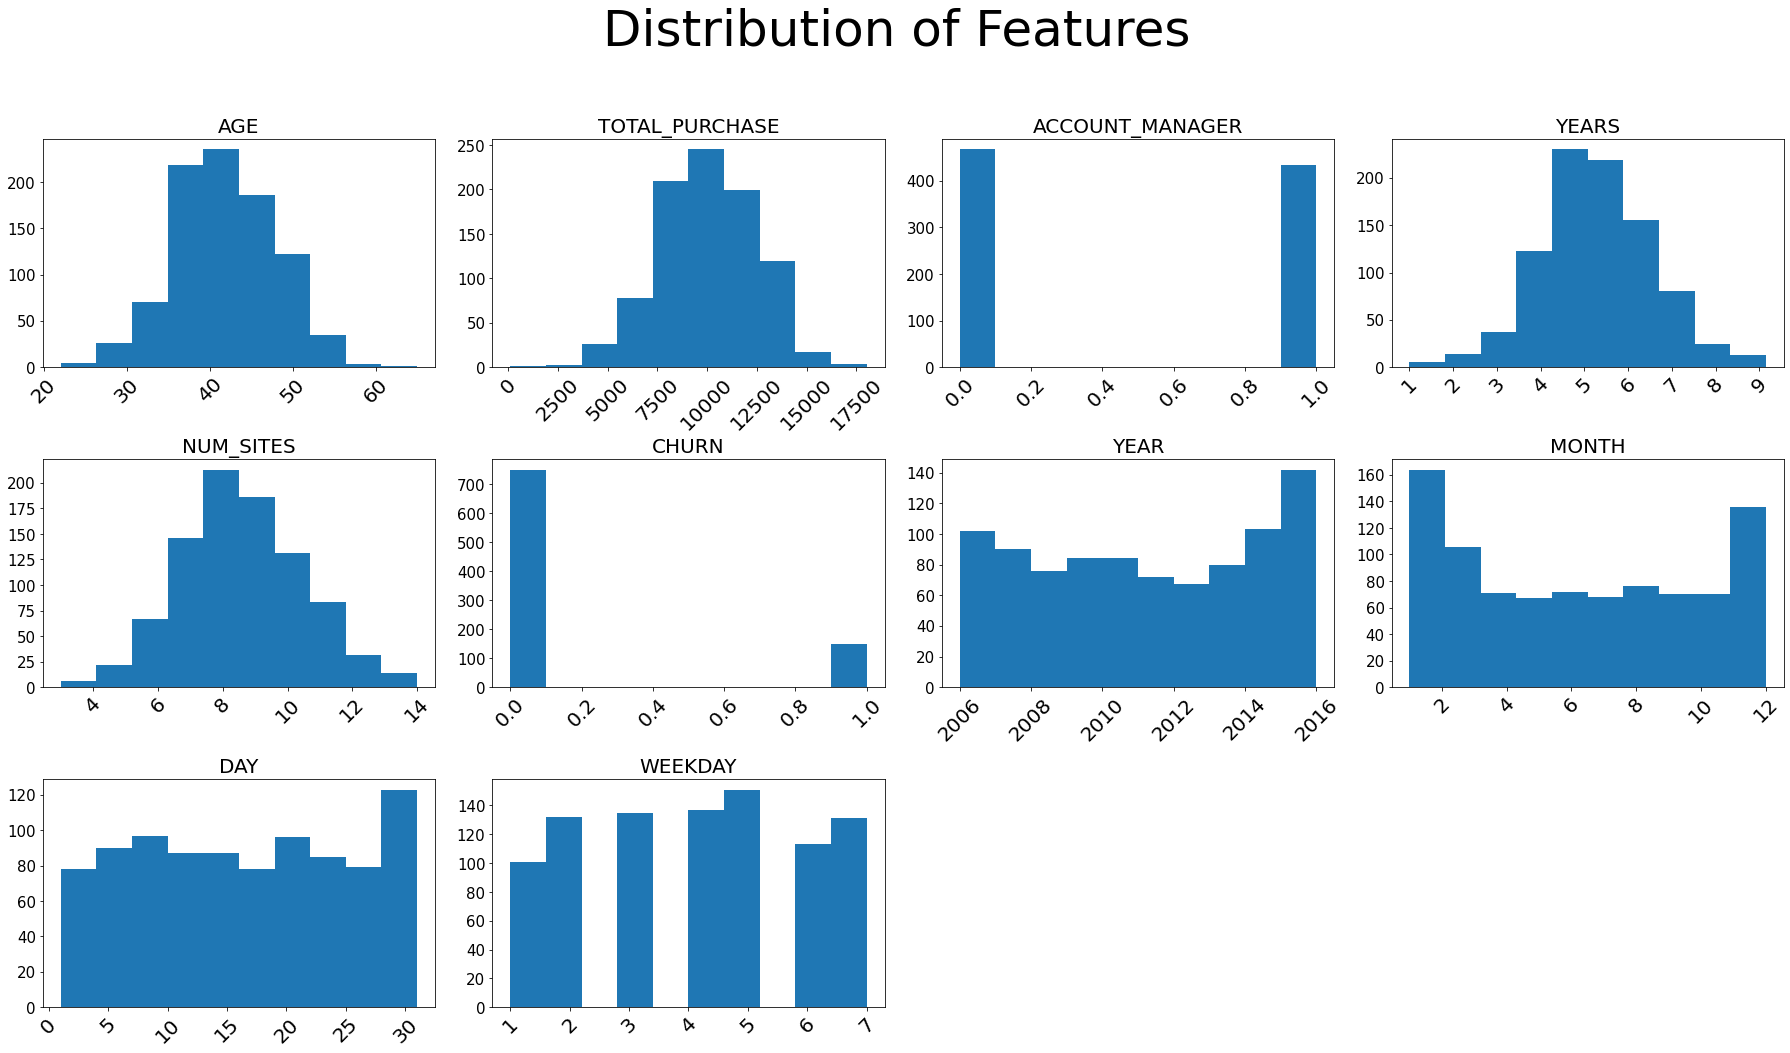

In [100]:
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df_data.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df_data.toPandas()[col])
    #plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

## Transformations

## Get numerical variables

In [101]:
numeric_features = [t[0] for t in df_data.dtypes if t[1] != 'string']
numeric_features_df = df_data.select(numeric_features)
numeric_features_df.toPandas().head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn,year,month,day,weekday,hour,minute
0,42.0,11066.80,0,7.22,8.0,1,2013,8,30,6,7,0
1,41.0,11916.22,0,6.50,11.0,1,2013,8,13,3,0,38
2,38.0,12884.75,0,6.67,12.0,1,2016,6,29,4,6,20
3,42.0,8010.76,0,6.71,10.0,1,2014,4,22,3,12,43
4,37.0,9191.58,0,5.56,9.0,1,2016,1,19,3,15,31


## Get categorical features

In [102]:
categorical_features = [t[0] for t in df_data.dtypes if t[1] == 'string']
categorical_features_df = df_data.select(categorical_features)
categorical_features_df.toPandas().head()

,Names,Location,Company
0,Cameron Williams,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC
1,Kevin Mueller,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC
2,Eric Lozano,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace"
3,Phillip White,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc
4,Cynthia Norton,"765 Tricia Row Karenshire, MH 71730",Love-Jones


## Calculate correlation matrix

In [103]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn,year,month,day,weekday,hour,minute
Age,1.000000,-0.037208,-0.014749,0.005625,-0.006070,0.085926,0.001595,0.010280,0.016058,0.016221,-0.019955,0.014922
Total_Purchase,-0.037208,1.000000,0.015856,-0.005623,-0.003390,0.024031,-0.024631,0.044835,0.007694,-0.001743,-0.004317,-0.011408
Account_Manager,-0.014749,0.015856,1.000000,0.022930,0.033401,0.070611,0.018814,0.028979,0.028306,-0.053856,-0.024162,-0.013818
Years,0.005625,-0.005623,0.022930,1.000000,0.051642,0.214329,-0.046624,0.015855,0.034310,-0.019375,-0.016724,0.008261
Num_Sites,-0.006070,-0.003390,0.033401,0.051642,1.000000,0.525398,-0.032777,0.008457,0.022000,-0.012073,-0.045056,-0.010174
Churn,0.085926,0.024031,0.070611,0.214329,0.525398,1.000000,-0.040150,0.019080,0.034398,-0.003606,-0.035145,-0.050551
year,0.001595,-0.024631,0.018814,-0.046624,-0.032777,-0.040150,1.000000,-0.039077,-0.033002,-0.035486,0.051154,-0.001306
month,0.010280,0.044835,0.028979,0.015855,0.008457,0.019080,-0.039077,1.000000,0.005801,0.019658,-0.003563,-0.021257
day,0.016058,0.007694,0.028306,0.034310,0.022000,0.034398,-0.033002,0.005801,1.000000,0.028348,-0.073284,-0.010616
weekday,0.016221,-0.001743,-0.053856,-0.019375,-0.012073,-0.003606,-0.035486,0.019658,0.028348,1.000000,-0.021089,-0.042082


## Plot correlation matrix

In [104]:
fig = go.Figure(data=go.Heatmap(
                   z=corr_df.values,
                   x=corr_df.columns,
                   y=corr_df.columns,
                   hoverongaps = False))
fig.show()

## Check NaN values

In [105]:
df_data.select([sf.count(sf.when(sf.isnan(c), c)).alias(c) for c in df_data.columns]).toPandas().head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Location,Company,Churn,year,month,day,weekday,hour,minute
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## method 1: Transformations step by step

### Index Categorical features
Convert categorical variables into indexed ones

In [106]:
df_aux0 = df_data

In [107]:
print(categorical_features)

['Names', 'Location', 'Company']


In [108]:
for categoricalCol in categorical_features:
    stringIndexer = StringIndexer(inputCol= categoricalCol,
                                  outputCol= categoricalCol + "_index")

    Index_model = stringIndexer.fit(df_aux0)
    df_aux0 = Index_model.transform(df_aux0)

df_aux0.toPandas().head(2)

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Location,Company,Churn,year,month,day,weekday,hour,minute,Names_index,Location_index,Company_index
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1,2013,8,30,6,7,0,629.0,709.0,824.0
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1,2013,8,13,3,0,38,717.0,710.0,1.0


### Encode categorical indexed variables
The categorical variables indexed are now encoded

In [109]:
df_aux1 = df_aux0
for feature in categorical_features:
    encoder = OneHotEncoderEstimator()\
                .setInputCols([feature + '_index'])\
                .setOutputCols([feature +  "_coded"])

    encoder_model = encoder.fit(df_aux1)
    df_aux1 = encoder_model.transform(df_aux1)

df_aux1.toPandas().head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Location,Company,Churn,year,...,day,weekday,hour,minute,Names_index,Location_index,Company_index,Names_coded,Location_coded,Company_coded
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1,2013,...,30,6,7,0,629.0,709.0,824.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1,2013,...,13,3,0,38,717.0,710.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1,2016,...,29,4,6,20,360.0,704.0,272.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Phillip White,42.0,8010.76,0,6.71,10.0,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1,2014,...,22,3,12,43,346.0,807.0,21.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1,2016,...,19,3,15,31,435.0,306.0,524.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Vector assembler
Vectorize both numerical and encoded categorical features

In [110]:
input_features = [c + '_coded' for c in categorical_features]
input_features

['Names_coded', 'Location_coded', 'Company_coded']

In [111]:
numeric_features.remove('Churn')

In [112]:
assemblerInputs = [c for c in input_features] + numeric_features
assemblerInputs

['Names_coded',
 'Location_coded',
 'Company_coded',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'year',
 'month',
 'day',
 'weekday',
 'hour',
 'minute']

In [113]:
assembler = VectorAssembler()\
         .setInputCols (assemblerInputs)\
         .setOutputCol ("vectorized_features")
        

df_aux2 = assembler.transform(df_aux1)
df_aux2.toPandas().head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Location,Company,Churn,year,...,weekday,hour,minute,Names_index,Location_index,Company_index,Names_coded,Location_coded,Company_coded,vectorized_features
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1,2013,...,6,7,0,629.0,709.0,824.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1,2013,...,3,0,38,717.0,710.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1,2016,...,4,6,20,360.0,704.0,272.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Phillip White,42.0,8010.76,0,6.71,10.0,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1,2014,...,3,12,43,346.0,807.0,21.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1,2016,...,3,15,31,435.0,306.0,524.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Label indexer

In [114]:
label_indexer = StringIndexer()\
         .setInputCol ("Churn")\
         .setOutputCol ("label")

label_indexer_model = label_indexer.fit(df_aux2)
df_aux3 = label_indexer_model.transform(df_aux2)

df_aux3.select("Churn","label").toPandas().head()

,Churn,label
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0


### Scale features 
To make them vary in the same range

In [176]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model = scaler.fit(df_aux3)
df_aux4 = scaler_model.transform(df_aux3)

df_aux4.select("vectorized_features","features").toPandas().head(5)

,vectorized_features,features
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [177]:
df_aux4.toPandas().head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Location,Company,Churn,year,...,minute,Names_index,Location_index,Company_index,Names_coded,Location_coded,Company_coded,vectorized_features,label,features
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1,2013,...,0,629.0,709.0,824.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1,2013,...,38,717.0,710.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1,2016,...,20,360.0,704.0,272.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Phillip White,42.0,8010.76,0,6.71,10.0,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1,2014,...,43,346.0,807.0,21.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1,2016,...,31,435.0,306.0,524.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [117]:
df_aux4.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- Names_index: double (nullable = false)
 |-- Location_index: double (nullable = false)
 |-- Company_index: double (nullable = false)
 |-- Names_coded: vector (nullable = true)
 |-- Location_coded: vector (nullable = true)
 |-- Company_coded: vector (nullable = true)
 |-- vectorized_features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



## Method 2: Pipeline transformations

In [118]:
categorical_features = [t[0] for t in df_data.dtypes if t[1] == 'string']

stringIndexer1 = StringIndexer()\
                 .setInputCol ("Names")\
                 .setOutputCol ("Names_index")
stringIndexer2 = StringIndexer()\
                 .setInputCol ("Location")\
                 .setOutputCol ("Location_index")
stringIndexer3 = StringIndexer()\
                 .setInputCol ("Company")\
                 .setOutputCol ("Company_index")

input_index_features = [c + '_index' for c in categorical_features]
output_coded_features = [c + '_coded' for c in categorical_features]

encoder = OneHotEncoderEstimator()\
         .setInputCols (input_index_features)\
         .setOutputCols (output_coded_features)

numerical_features = [t[0] for t in df_data.dtypes if t[1] != 'string']
numerical_features.remove('Churn')
assemblerInputs = [c for c in output_coded_features] + numerical_features

assembler = VectorAssembler()\
         .setInputCols (assemblerInputs)\
         .setOutputCol ("vectorized_features")

label_indexer = StringIndexer()\
         .setInputCol ("Churn")\
         .setOutputCol ("label")

scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")

pipeline_stages = Pipeline().setStages([stringIndexer1,
                                        stringIndexer2,
                                        stringIndexer3,
                                        encoder,
                                        assembler,
                                        label_indexer,
                                        scaler])

### Apply pipeline

In [119]:
pipeline_model = pipeline_stages.fit(df_data)
df_aux5 = pipeline_model.transform(df_data)

### compare method 1 with method 2

In [180]:
df_aux4.select(output_coded_features + input_index_features + ['features','label']).toPandas().head()

,Names_coded,Location_coded,Company_coded,Names_index,Location_index,Company_index,features,label
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",629.0,709.0,824.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",717.0,710.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",360.0,704.0,272.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",346.0,807.0,21.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",435.0,306.0,524.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [181]:
df_aux5.select(output_coded_features + input_index_features + ['features','label']).toPandas().head()

,Names_coded,Location_coded,Company_coded,Names_index,Location_index,Company_index,features,label
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",629.0,709.0,824.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",717.0,710.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",360.0,704.0,272.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",346.0,807.0,21.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",435.0,306.0,524.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


## features/target split
Realice la separación en los conjuntos de entrenamiento y prueba con una proporción 70-30. Muestre los primeros 5 elementos de cada conjunto de datos.

In [121]:
df_T = df_aux5.select('features', 'label')

In [122]:
y = df_T.select('label')
y.show(5)

+-----+
|label|
+-----+
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
+-----+
only showing top 5 rows



In [123]:
X = df_T.select('features')
X.toPandas().head()

,features
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Train-test split 


Separar features y target 
Obtenga el conjunto de datos con el vector de variables independientes y la variable dependiente (churn). Por simplicidad, es suficiente que seleccione únicamente las variables numéricas. Muestre los primeros 5 elementos.

In [182]:
train, test = df_T.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count:{} ".format(str(train.count())))
print("Test Dataset Count:{} ".format(str(test.count())))

Training Dataset Count:636 
Test Dataset Count:264 


In [128]:
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  531|
|  1.0|  105|
+-----+-----+



In [129]:
test.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  219|
|  1.0|   45|
+-----+-----+



## Model training 
Ajuste un modelo de regresión logística 
con los hiperparámetros por defecto. Muestre los estadísticos descriptivos de las predicciones contenidas en el resumen del modelo.

### Instantite model

In [183]:
lr = LogisticRegression(featuresCol = 'features',
                        labelCol = 'label',
                        maxIter=10)

### fit model

In [184]:
lrModel = lr.fit(train)

In [138]:
trainingSummary = lrModel.summary
pr = trainingSummary.pr.toPandas()
tp = trainingSummary.precisionByThreshold.toPandas()
fm = trainingSummary.fMeasureByThreshold.toPandas()

<img src="images/Precisionrecall.png">

__Precision__

precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly, and the  Precision is also known as positive predictive value. Indicate how many items selected are relevant

$$
Precision = \frac{TP}{TP + FP}
$$

TP: True Positive
FP: False Positive

<img src="images/Precision.png">

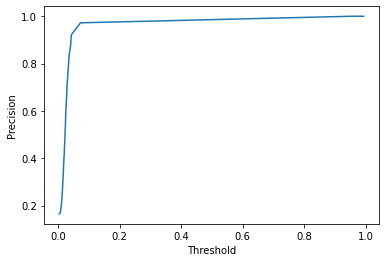

In [139]:
plt.plot(tp['threshold'], tp['precision'])
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

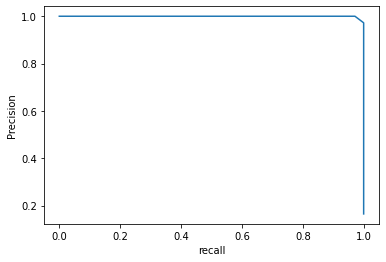

In [140]:
plt.plot(pr['recall'], pr['precision'])
plt.xlabel('recall')
plt.ylabel('Precision')
plt.show()

__Recall__

recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.
recall is also known as sensitivity in diagnostic binary classification. Indicate how many relevant items selected are selected

$$
Recall = \frac{TP}{TP + FN}
$$

TP: True Positive
FN: False Negative

<img src="images/recall.png">

In [148]:
# Plot the threshold-recall curve
#plt.plot(tp['threshold'], pr['recall'])
#plt.xlabel('Threshold')
#plt.ylabel('Recall')
#plt.show()

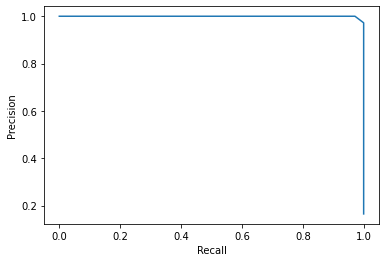

In [149]:
# Plot the recall-precision curve
plt.plot(pr['recall'], pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

__F-score ($F_1$)__

It measure of a test's accuracy. It is calculated from the precision and recall

$$
F_1 =2 \cdot \frac{precision \cdot recall}{precision + recall}
$$

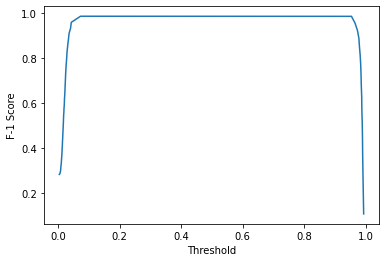

In [150]:
# Plot the threshold-F-Measure curve 
plt.plot(fm['threshold'], fm['F-Measure'])
plt.xlabel('Threshold')
plt.ylabel('F-1 Score')
plt.show()

### Get predictions
Evalúe los resultados en el conjunto de prueba. Muestre las primeras 5 predicciones.

In [151]:
predictions = lrModel.transform(test)

In [152]:
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.0852919159828036, -2.0852919159828036]",0.0,"[0.8894653903657646, 0.11053460963423536]"
1,0.0,"(0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.3314620522177885, -2.3314620522177885]",0.0,"[0.9114494090854199, 0.08855059091458001]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.325136849652714, -2.325136849652714]",0.0,"[0.910937575543443, 0.08906242445655707]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.1368591705218307, -3.1368591705218307]",0.0,"[0.9583878026438415, 0.04161219735615841]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.795978601318186, -2.795978601318186]",0.0,"[0.942458128053784, 0.05754187194621599]"


## Model evaluation

In [153]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Plot confusion matrix

Confusion matrix, without normalization
[[  0  45]
 [  0 219]]


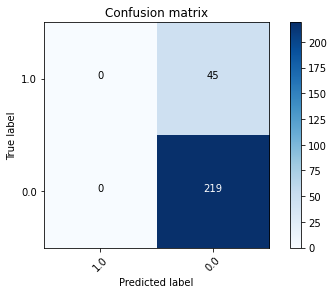

In [154]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

class_names = [1.0,0.0]

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)

#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix')
plt.show()

### Accuracy

In [155]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : {} % ".format(round(100*accuracy,2)))

Accuracy : 82.95 % 


### ROC curve
Para evaluar el desempeño del modelo, obtenga el valor del indicador auROC (área debajo de la curva ROC).

Train Area Under ROC: 0.9999192897497983
Test Area Under ROC 0.926128868594622


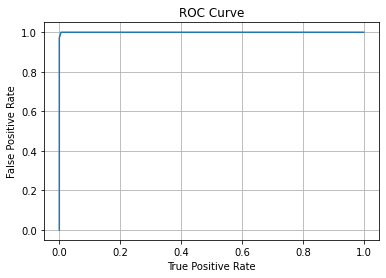

In [156]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()

print('Train Area Under ROC: ' + str(trainingSummary.areaUnderROC))
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()

## Inference
Repeat with new data
Cargue los datos del archivo 'data_new.csv' y obtenga las predicciones sobre ese conjunto de datos utilizando los objetos construidos previamente. Muestre los primeros 5 elementos.

In [225]:
df_data_new = spark.read.csv(path='data_new.csv', sep=',',encoding='UTF-8',comment=None, header=True, inferSchema=True)

In [226]:
df_data_new.toPandas().head(5)

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company
0,Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd
1,Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson
2,Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson
3,Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden
4,Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC


In [227]:
df_data_new.toPandas().describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,35.166667,7607.156667,0.833333,6.808333,12.333333
std,15.715173,4346.008233,0.408248,3.708738,3.386247
min,22.000000,100.000000,0.000000,1.000000,8.000000
25%,25.250000,6747.360000,1.000000,4.522500,9.500000
50%,32.000000,7986.100000,1.000000,8.495000,14.000000
75%,35.750000,9562.962500,1.000000,9.370000,14.750000
max,65.000000,13147.710000,1.000000,10.000000,15.000000


### Transform timestamp in features-time based

In [228]:
df_data_new = df_data_new.withColumn("year", sf.year(sf.col("Onboard_date")))
df_data_new = df_data_new.withColumn("month", sf.month(sf.col("Onboard_date")))
df_data_new = df_data_new.withColumn("day", sf.dayofmonth(sf.col("Onboard_date")))
df_data_new = df_data_new.withColumn("weekday", sf.dayofweek(sf.col("Onboard_date")))
df_data_new = df_data_new.withColumn("hour", sf.hour(sf.col("Onboard_date")))
df_data_new = df_data_new.withColumn("minute", sf.minute(sf.col("Onboard_date")))
df_data_new = df_data_new.drop("Onboard_date")

### Create random label

In [229]:
df_data_new = df_data_new.withColumn('Churn', sf.round(sf.rand(df_data_new.count()),1))
y_udf = sf.udf(lambda y: 0 if y<=0.5 else 1)
df_data_new = df_data_new.withColumn("Churn", y_udf('Churn'))
df_data_new = df_data_new.withColumn("Churn", df_data_new["Churn"].cast(IntegerType()))
df_data_new.toPandas().head(2)

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Location,Company,year,month,day,weekday,hour,minute,Churn
0,Andrew Mccall,37.0,9935.53,1,7.71,8.0,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd,2011,8,29,2,18,37,0
1,Michele Wright,23.0,7526.94,1,9.28,15.0,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson,2013,7,22,2,18,19,1


In [235]:
df_data.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [234]:
df_data_new.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|    3|
|    0|    3|
+-----+-----+



In [230]:
df_data_new.dtypes

[('Names', 'string'),
 ('Age', 'double'),
 ('Total_Purchase', 'double'),
 ('Account_Manager', 'int'),
 ('Years', 'double'),
 ('Num_Sites', 'double'),
 ('Location', 'string'),
 ('Company', 'string'),
 ('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('weekday', 'int'),
 ('hour', 'int'),
 ('minute', 'int'),
 ('Churn', 'int')]

### Apply again pipeline transformations

In [273]:
pipeline_model = pipeline_stages.fit(df_data_new)
df_aux6 = pipeline_model.transform(df_data_new)

In [277]:
data_set_inference = df_aux6.select('label','features')

In [282]:
inference = lrModel.transform(data_set_inference)

try:
    accuracy = inference.filter(inference.label == inference.prediction).count() / float(inference.count())
    print("Accuracy : {} % ".format(round(100*accuracy,2)))

    inference.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)
    
except Exception as e:
    print(e)
    
  

An error occurred while calling o7231.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 586.0 failed 1 times, most recent failure: Lost task 0.0 in stage 586.0 (TID 5277, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterato

### concat new data with all the original data

In [254]:
df_data_total = df_data.union(df_data_new)

In [232]:
df_data_total.toPandas().head(2)

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Location,Company,Churn,year,month,day,weekday,hour,minute
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1,2013,8,30,6,7,0
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1,2013,8,13,3,0,38


In [233]:
df_data_total.groupby("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
| 2006|    1|
| 2013|    1|
|    1|  150|
| 2012|    1|
| 2016|    1|
| 2011|    2|
|    0|  750|
+-----+-----+



In [255]:
df_data_total.filter((df_data_total.Churn!=0) & (df_data_total.Churn!=1)).toPandas().head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Location,Company,Churn,year,month,day,weekday,hour,minute
0,Andrew Mccall,37.0,9935.53,1,7.71,8.0,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd,2011,8,29,2,18,37,0
1,Michele Wright,23.0,7526.94,1,9.28,15.0,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson,2013,7,22,2,18,19,1
2,Jeremy Chang,65.0,100.00,1,1.00,15.0,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson,2006,12,11,2,7,48,0
3,Megan Ferguson,32.0,6487.50,0,9.40,14.0,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden,2016,10,28,6,5,32,0
4,Taylor Young,32.0,13147.71,1,10.00,8.0,Unit 0789 Box 0734 DPO AP 39702,Wood LLC,2012,3,20,3,0,36,1


In [257]:
df_data_total = df_data_total.filter((df_data_total.Churn==0) | (df_data_total.Churn==1))

In [259]:
df_data_total.toPandas().head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Location,Company,Churn,year,month,day,weekday,hour,minute
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1,2013,8,30,6,7,0
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1,2013,8,13,3,0,38
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1,2016,6,29,4,6,20
3,Phillip White,42.0,8010.76,0,6.71,10.0,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1,2014,4,22,3,12,43
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1,2016,1,19,3,15,31


In [260]:
pipeline_model = pipeline_stages.fit(df_data_total)
df_data_total_aux = pipeline_model.transform(df_data_total)

In [290]:
inference = lrModel.transform(df_data_total_aux.select('features','label'))

accuracy = inference.filter(inference.label == inference.prediction).count() / float(inference.count())
print("Accuracy : {} % ".format(round(100*accuracy,2)))

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
print('AUC: ' + str(round(trainingSummary.areaUnderROC,4)))

inference.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

Accuracy : 95.0 % 
AUC: 0.9999


,label,features,rawPrediction,prediction,probability
0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.288783509875724, 5.288783509875724]",1.0,"[0.005022543957491691, 0.9949774560425083]"
1,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.524420168985268, 3.524420168985268]",1.0,"[0.028625332631197393, 0.9713746673688025]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.940355803788232, -3.940355803788232]",0.0,"[0.980929459793582, 0.019070540206417963]"
3,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.888460664417213, 5.888460664417213]",1.0,"[0.002763580739029856, 0.9972364192609702]"
4,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.8873876397365965, -5.8873876397365965]",0.0,"[0.9972334604873653, 0.0027665395126348267]"
